In [1]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
%matplotlib inline
import numpy as np
import pandas as pd
from numpy.linalg import norm
import scipy as sp
from scipy.io import loadmat
from sympy import *

In [2]:
image = loadmat('train.mat')['X'].T
y = loadmat('train.mat')['y']
imagetest = loadmat('test.mat')['X'].T

In [6]:
image.dtype

dtype('uint8')

In [7]:
image[:, :, :,1].shape

(32, 32, 3)

In [4]:
def display_stats(X,y,sample_id):
    features, labels = X,y

    if not (0 <= sample_id < len(features)):
        print('{} samples {}.  {} is out of range.'.format(len(features), sample_id))
        return None

    sample_image = features[sample_id].T
    sample_label = labels[sample_id]

    print('Example of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} '.format(sample_label))
    plt.axis('off')
    plt.imshow(sample_image)

Example of Image 200:
Image - Min Value: 45 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: [5] 


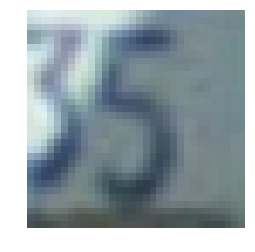

In [6]:
display_stats(image, y, 200)

In [10]:
# Normalize data
Xtrain=image/255
Xtest=image/255

In [11]:
Xtrain.shape

(73257, 3, 32, 32)

In [7]:
np.min(y)

1

In [8]:
# one-hot encoding of the labels
from sklearn import preprocessing

labels= np.array(range(np.max(y)))
lb = preprocessing.LabelBinarizer()
lb.fit(labels)
y_oh= lb.transform(y)

In [12]:
k= np.zeros(shape=(73257, 32, 32, 3))
for i, j in enumerate(Xtrain):
    k[i]=j.T

In [13]:
Xtrain=k
Xtrain.shape

(73257, 32, 32, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(Xtrain, y_oh, test_size=0.2, random_state=42)

In [7]:
y_valid.shape

(14652, 10)

In [16]:
X_train=np.float16(X_train)
X_valid=np.float16(X_valid)
y_train=np.uint8(y_train)
y_valid=np.uint8(y_valid)

In [5]:
X_train.dtype

dtype('float16')

In [30]:
data={'X_train': X_train, 'X_valid':X_valid, 'y_train':y_train,'y_valid':y_valid}

In [21]:
# Save data in file
np.savez("data1.npz",  X_train= X_train, X_valid=X_valid, y_train=y_train,y_valid=y_valid)

In [2]:
# Read from file
npzfile = np.load("data1.npz")
npzfile.files

['X_train', 'y_valid', 'X_valid', 'y_train']

In [3]:
X_train=npzfile['X_train']
y_train=npzfile['y_train']
X_valid=npzfile['X_valid']
y_valid=npzfile['y_valid']

In [4]:
X_train=X_train[1:20000]
y_train=y_train[1:20000]

In [5]:
X_train.shape

(19999, 32, 32, 3)

In [10]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

C:\Users\sandra\Anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
batch_size = 64
epochs = 2
num_classes = 10

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(32,32,3),padding='same'))
#model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.5))
#model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
#model.add(Activation('relu'))                  
#model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(Activation('relu'))                  
model.add(Dense(num_classes, activation='softmax'))

In [13]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
model_train = model.fit(X_train, y_train, batch_size=batch_size,
                        epochs=epochs,verbose=1,validation_data=(X_valid, y_valid))

Train on 9999 samples, validate on 14652 samples
Epoch 1/2


In [6]:
import tensorflow as tf

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /gpu:0


In [7]:
# define input
def neural_net_image_input(image_shape):

    x=tf.placeholder(tf.float32,[None,image_shape[0],image_shape[1],image_shape[2]], name='x')
    return x


def neural_net_label_input(n_classes):

    y = tf.placeholder(tf.float32, [None, n_classes], name='y')
    return y


def neural_net_keep_prob_input():

    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    return keep_prob

In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):

    weights = tf.Variable(tf.truncated_normal([conv_ksize[0],conv_ksize[1], 
                                               x_tensor.get_shape().as_list()[3],conv_num_outputs],stddev=0.08))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
                          
    conv_layer = tf.nn.conv2d(x_tensor, weights, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    conv_layer=tf.nn.relu(conv_layer)
    
    output= tf.nn.max_pool(conv_layer, ksize=[1, pool_ksize[0], pool_ksize[1], 1], 
                           strides=[1, pool_ksize[0], pool_ksize[1], 1], padding='VALID')
    return output 

In [9]:
# Flattened Image Size
import numpy as np

def flatten(x_tensor):
    
    shape = x_tensor.get_shape().as_list() 
    dim = np.prod(shape[1:])    
    output = tf.reshape(x_tensor, [-1, dim]) 
    
    return output

In [10]:
def fully_conn(x_tensor, num_outputs):

    
    flatten_layer = flatten(x_tensor)
    
    weights = tf.Variable(tf.truncated_normal([flatten_layer.get_shape().as_list()[1],num_outputs], stddev=0.08))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    fc_layer = tf.add(tf.matmul(flatten_layer, weights), bias)
    output = tf.nn.relu(fc_layer)
    
    return output

In [11]:
def output(x_tensor, num_outputs):
    
    flatten_layer = flatten(x_tensor)
    
    weights = tf.Variable(tf.truncated_normal([flatten_layer.get_shape().as_list()[1],num_outputs], stddev=0.08))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    output = tf.add(tf.matmul(flatten_layer, weights), bias)
    
    return output

In [12]:
def conv_net(x, keep_prob,num_classes =10):
    
    conv1= conv2d_maxpool(x, conv_num_outputs=64,
                           conv_ksize=[5,5],
                           conv_strides=[1,1],
                           pool_ksize=[3,3],
                           pool_strides=[2,2])
    
    conv2= conv2d_maxpool(conv1, 128, [5,5], [1,1], [2,2], [2,2])
    #conv3= conv2d_maxpool(conv2, 128, [2,2], [1,1], [2,2], [2,2])

    flatten_layer = flatten(conv2)

    fc1=fully_conn(flatten_layer, 384)
    fc2=fully_conn(fc1, 192)
    
    fc = tf.nn.dropout(fc2, keep_prob)
    out= output(fc, num_classes)

    return out

In [13]:
# Build the Neural Network

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [14]:
def train_neural_network(session, optimizer, keep_probability, feature, label):
    session.run(optimizer, feed_dict={x: feature,
                                      y: label,
                                      keep_prob: keep_probability})  

In [15]:
def print_stats(session, feature, label, cost, accuracy):

    loss=session.run(cost,feed_dict={x: feature,y: label,keep_prob: 1.})
    acc=session.run(accuracy,feed_dict={x: X_valid, y: y_valid, keep_prob: 1.})
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, acc))

In [16]:
# set parameters
epochs = 3
batch_size = 64
keep_probability = 0.75

In [17]:
# Split features and labels into batches
def batch_features_labels(features, labels, batch_size):
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [ ]:
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        for feature, label in batch_features_labels(X_train,y_train,batch_size):
            train_neural_network(sess, optimizer, keep_probability, feature,label)
        print('Epoch {:>2}:  '.format(epoch + 1), end='')
        print_stats(sess, feature, label, cost, accuracy)

In [ ]:
def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])